# sparsecluster demo

`sparsecluster` is a wrapper around `pynndescent` for efficient construction of nearest-neighbor graphs and `gbbs` for graph-based hierarchical clustering. the basic idea is to use an approximate distance matrix as input for linkage, in order to allow for clustering of large (and sparse) datasets

In [1]:
import numpy as np
import sparsecluster
import fastcluster
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy
import sklearn.cluster
import scipy.cluster
import sklearn.datasets
import pandas as pd
import time
import seaborn as sns

## simple demo example

for initial demo, use a random matrix for 10 samples and 5 features

In [2]:
np.random.seed(0)
X=np.random.rand(10,5)

as baseline, we construct a full distance matrix using `scipy.spatial.distance.pdist` and an exact linkage using `fastcluster`

In [3]:
metric='euclidean'
d0 = scipy.spatial.distance.pdist(X, metric=metric)
Z0s = fastcluster.linkage(d0, metric=metric, method='single')

now we use `sparsecluster` to construct distances and linkages for either 10 neighbors (i.e., the full matrix) or 5 neighbors (an approximation). during nearest-neighbor descent, we can store additional distances for `n_backup` non-nearest neighbors. 

In [4]:
Z1s,d1 = sparsecluster.linkage(X, metric=metric, method='single', n_neighbors=10, return_distance=True)
Z2s,d2 = sparsecluster.linkage(X, metric=metric, method='single', n_neighbors=5, n_backup=0, return_distance=True)

Text(0.5, 1.0, '5 nearest neighbors')

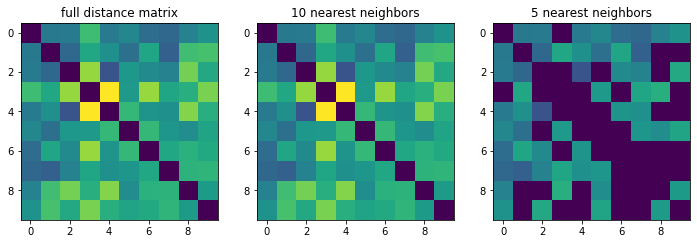

In [5]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(scipy.spatial.distance.squareform(d0), cmap=plt.cm.viridis, vmin=0, vmax=d0.max())
axs[0].set_title('full distance matrix')
axs[1].imshow(d1.todense(), cmap=plt.cm.viridis, vmin=0, vmax=d0.max())
axs[1].set_title('10 nearest neighbors')
axs[2].imshow(d2.todense(), cmap=plt.cm.viridis, vmin=0, vmax=d0.max())
axs[2].set_title('5 nearest neighbors')

even though the sparse approximation is missing entries for larger distances, the resulting dendrograms (using single linkage) are equivalent, possibly up to a re-ordering

Text(0.5, 1.0, '5 neighbors')

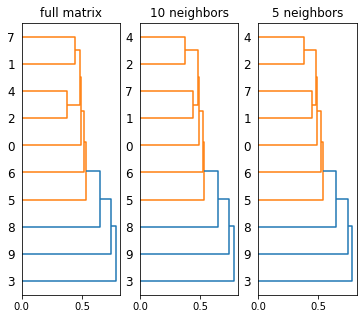

In [6]:
fig,axs=plt.subplots(1,3,figsize=(6,5),sharex=True)
L0=scipy.cluster.hierarchy.dendrogram(Z0s,ax=axs[0],orientation='right')
L1=scipy.cluster.hierarchy.dendrogram(Z1s,ax=axs[1],orientation='right')
L2=scipy.cluster.hierarchy.dendrogram(Z2s,ax=axs[2],orientation='right')
axs[0].set_title('full matrix')
axs[1].set_title('10 neighbors')
axs[2].set_title('5 neighbors')

try the same thing with complete or weighted linkage (but skipping the re-calculation of the distance matrices): 5 nearest neighbors is not always enough

In [7]:
Z0c = fastcluster.linkage(d0, metric=metric, method='complete')
Z1c = sparsecluster.linkage(X, dist=d1, metric=metric, method='complete', n_neighbors=10)
Z2c = sparsecluster.linkage(X, dist=d2, metric=metric, method='complete', n_neighbors=5)

Z0w = fastcluster.linkage(d0, metric=metric, method='weighted')
Z1w = sparsecluster.linkage(X, dist=d1, metric=metric, method='weighted', n_neighbors=10)
Z2w = sparsecluster.linkage(X, dist=d2, metric=metric, method='weighted', n_neighbors=5)

Text(0, 0.5, 'weighted linkage')

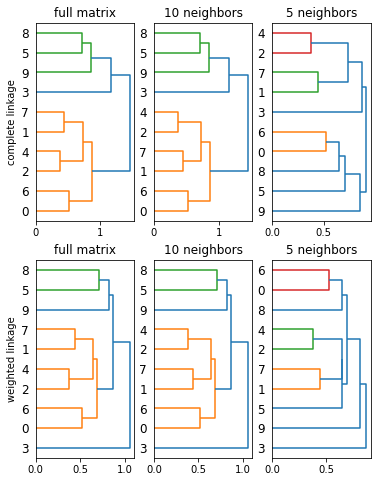

In [8]:
fig,axs=plt.subplots(2,3,figsize=(6,8))

L0=scipy.cluster.hierarchy.dendrogram(Z0c,ax=axs[0,0],orientation='right')
L1=scipy.cluster.hierarchy.dendrogram(Z1c,ax=axs[0,1],orientation='right')
L2=scipy.cluster.hierarchy.dendrogram(Z2c,ax=axs[0,2],orientation='right')

L0=scipy.cluster.hierarchy.dendrogram(Z0w,ax=axs[1,0],orientation='right')
L1=scipy.cluster.hierarchy.dendrogram(Z1w,ax=axs[1,1],orientation='right')
L2=scipy.cluster.hierarchy.dendrogram(Z2w,ax=axs[1,2],orientation='right')

axs[0,0].set_title('full matrix')
axs[0,1].set_title('10 neighbors')
axs[0,2].set_title('5 neighbors')

axs[1,0].set_title('full matrix')
axs[1,1].set_title('10 neighbors')
axs[1,2].set_title('5 neighbors')

axs[0,0].set_ylabel("complete linkage")
axs[1,0].set_ylabel("weighted linkage")

## how many neighbors are needed?

use the `digits` dataset to compare the `sparsecluster` linkages to the `fastcluster` linkages 

In [9]:
digits = sklearn.datasets.load_digits()
X, y = digits.data, digits.target

In [10]:
nc=10
metric='cosine'

fastcluster_linkage = {}
for method in ("single", "complete", "weighted"):
    fastcluster_linkage[method] = fastcluster.linkage(X, method=method, metric=metric)
    
sparsecluster_linkage = {}
for nfrac in [.01, .02, .05, .1, .2, .5]:
    for bfrac in [0, 1, 5]:
        nn = int(nfrac*X.shape[0])
        for r in range(3):
            Zs, ds = sparsecluster.linkage(X, metric=metric, method='single', 
                                           n_neighbors=nn, n_backup=bfrac*nn, 
                                           n_jobs=8, random_state=r,
                                           return_distance=True)
            
            Zc = sparsecluster.linkage(X, dist=ds, metric=metric, method='complete')           
            Zw = sparsecluster.linkage(X, dist=ds, metric=metric, method='weighted')           

            sparsecluster_linkage[('single',nfrac, bfrac, r)] = Zs
            sparsecluster_linkage[('complete',nfrac, bfrac, r)] = Zc
            sparsecluster_linkage[('weighted',nfrac, bfrac, r)] = Zw

we use "cophenetic distances" (i.e., distances along the tree) to compare the linkages. here's a scatter plot of cophenetic distances for fastcluster vs. sparsecluster linkage (10% neighbors calculated). for single linkage, the results are identical, for average or complete linkage they are similar for small distances and more divergent for larger ones

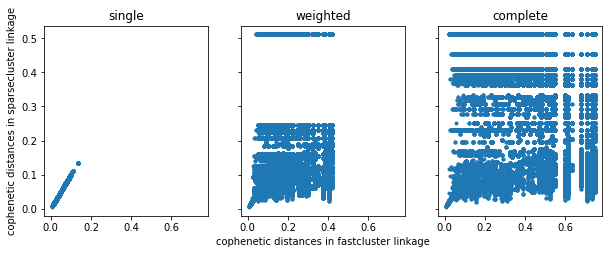

In [11]:
fig,axs=plt.subplots(1,3,figsize=(10,3.5), sharex=True, sharey=True)
for n,method in enumerate(['single','weighted','complete']):
    d1=scipy.cluster.hierarchy.cophenet(fastcluster_linkage[method])
    d2=scipy.cluster.hierarchy.cophenet(sparsecluster_linkage[(method,.01,1,0)])
    axs[n].plot(d1,d2,'.')
    if n==1:
        axs[n].set_xlabel('cophenetic distances in fastcluster linkage')
    if n==0:
        axs[n].set_ylabel('cophenetic distances in sparsecluster linkage')
    axs[n].set_title(method)

more systematically, we can calculate the correlation between these cophenetic distances for different linkage methods and different number of neighbors and backup distances stored: for single linkage, the two methods give identical results, while for weighted or complete linkage, only small cophenetic distances are correctly reproduced. including backup distances helps especially for few neighbors and weighted linkage

In [12]:
cc=dict((k,scipy.stats.pearsonr(scipy.cluster.hierarchy.cophenet(fastcluster_linkage[k[0]]),
                                scipy.cluster.hierarchy.cophenet(sparsecluster_linkage[k]))[0]) 
        for k in sparsecluster_linkage.keys())

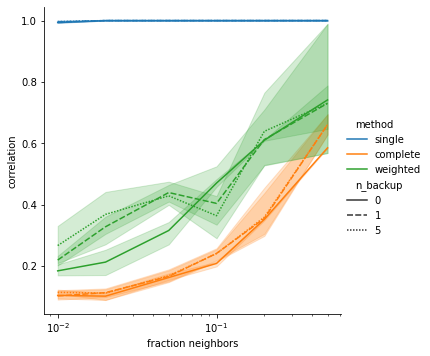

In [13]:
g=sns.relplot(data=pd.Series(cc).reset_index().rename({'level_1': 'fraction neighbors',
                                                     'level_2': 'n_backup',
                                                     'level_0': 'method',
                                                     0: 'correlation'},axis=1),     
            x='fraction neighbors',y='correlation',style='n_backup',hue='method', kind='line')
g.ax.set_xscale('log')

## benchmarking time and memory usage

use the `20newsgroups_vectorized` sparse dataset for benchmarking

In [14]:
%load_ext memory_profiler

data,labels = sklearn.datasets.fetch_20newsgroups_vectorized(subset='train',
                                                             data_home='.',
                                                             return_X_y=True)
data_dense=np.asarray(data.todense())
data

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

here's time and memory usage for `sparsecluster`

In [15]:
%%time 
%memit Zs = sparsecluster.linkage(data, metric='cosine', method='single',  n_neighbors=100, n_backup=500, n_jobs=8)

peak memory: 7001.49 MiB, increment: 1468.89 MiB
CPU times: user 42min 56s, sys: 1min 5s, total: 44min 1s
Wall time: 6min 35s


here's time and memory usage for `sparsecluster`, but with dense input

In [16]:
%%time 
%memit Zs = sparsecluster.linkage(data_dense, metric='cosine', method='single',  n_neighbors=100, n_backup=500, n_jobs=8)

peak memory: 14599.66 MiB, increment: 7598.12 MiB
CPU times: user 10h 59min 40s, sys: 10min 32s, total: 11h 10min 13s
Wall time: 1h 26min 56s


here's time and memory usage for `fastcluster`

In [17]:
%%time 
%memit Z0 = fastcluster.linkage(data_dense, metric='cosine', method='single')

peak memory: 13570.23 MiB, increment: 0.00 MiB
CPU times: user 4h 9min 18s, sys: 11min 40s, total: 4h 20min 59s
Wall time: 1h 11min 56s
